In [28]:
import os
import sys
import random
import numpy as np
import pandas as pd
import cv2
from imutils import paths
import matplotlib.pyplot as plt
%matplotlib inline


Lets start by analyzing the number of images in each class for the training set

In [29]:
pneumonia_train = list(paths.list_images("chest_xray/train/PNEUMONIA/"))
normal_train = list(paths.list_images("chest_xray/train/NORMAL/"))
print(len(pneumonia_train))
print(len(normal_train))

3875
1341


Let's go into each class and randomly display some images to get an idea of how they look. But first lets make a function to do this for us.

['chest_xray/train/PNEUMONIA/person602_bacteria_2460.jpeg', 'chest_xray/train/PNEUMONIA/person1048_virus_1744.jpeg', 'chest_xray/train/PNEUMONIA/person23_bacteria_80.jpeg']
['chest_xray/train/NORMAL/NORMAL2-IM-0428-0001.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-1412-0001.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-1271-0001.jpeg']


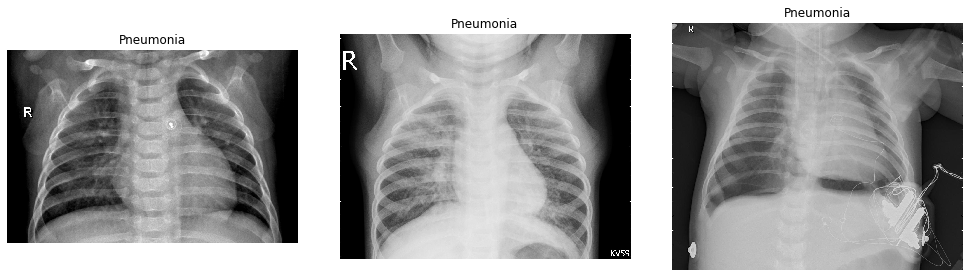

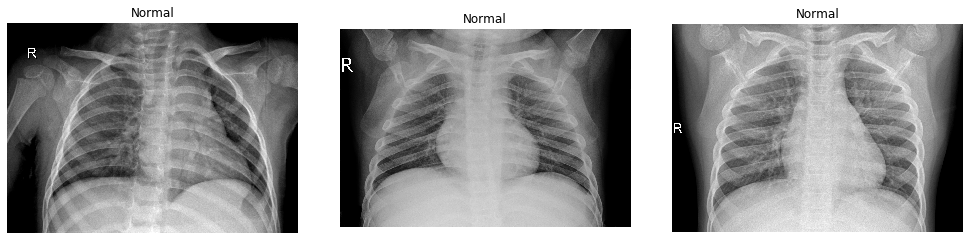

In [43]:

def read_image_rgb(im_path):
    return cv2.cvtColor(
        cv2.imread(im_path), cv2.COLOR_BGR2RGB
    )
    
# define classes
classes = {
    "Pneumonia":pneumonia_train, 
    "Normal": normal_train
}
columns = 3
for _class in classes:
    random_images = random.sample(classes[_class], columns)
    print(random_images)
    fig, axes = plt.subplots(nrows=1, ncols=columns, figsize=(14, 10), squeeze=False)
    fig.tight_layout()
    for l in range(1):
        for m, img in enumerate(random_images):
            axes[l][m].imshow(read_image_rgb(img))
            axes[l][m].axis("off")
            axes[l][m].set_title(_class)
# done displaying

Let us do some preprocessing that will bring up the contrast in the images. The approach is,

-> RGB -> HSV -> H, S, V -> H, S, HistogramEqulize(V) -> HSV -> RGB

In [140]:
# display function
def display(image, title=None):
    fig = plt.figure(figsize=(10, 10))
    #plt.imshow(image, cmap="gray")
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [141]:
def preprocess(image):
    # BGR to HSV
    img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # split to H,S,V
    H, S, V = cv2.split(img)
    # histogram equalize
    V = cv2.equalizeHist(V)
    # join back
    img = cv2.merge([H, S, V])
    # HSV to RGB
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    
    return img

In [142]:
_image = cv2.imread(str(random.sample(pneumonia_train, 1)[0]))
_image_processed = preprocess(_image)

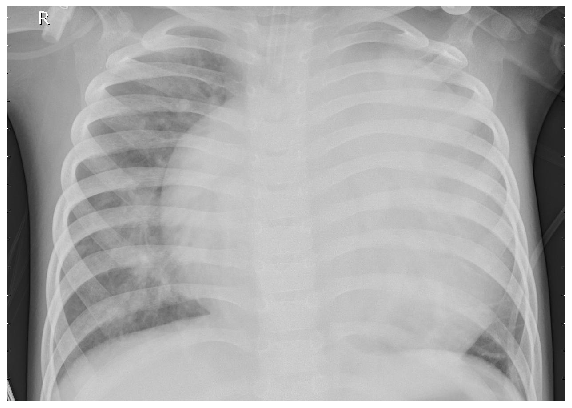

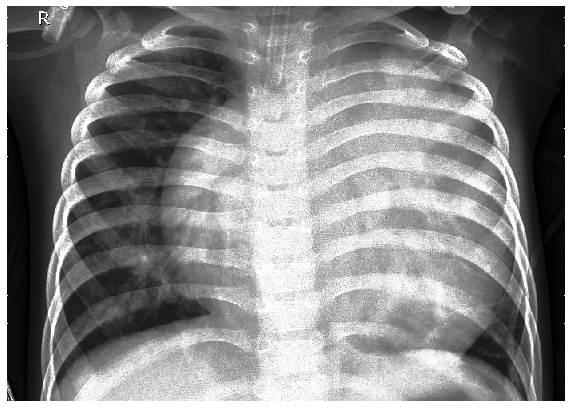

In [144]:
display(_image)
display(_image_processed)

In [137]:
img = cv2.imread("chest_xray/train/PNEUMONIA/person1411_bacteria_3599.jpeg")
_img = img
# BGR to HSV
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# split to H,S,V
H, S, V = cv2.split(img)
# histogram equalize
V = cv2.equalizeHist(V)
# join back
img = cv2.merge([H, S, V])
# HSV to RGB
img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)


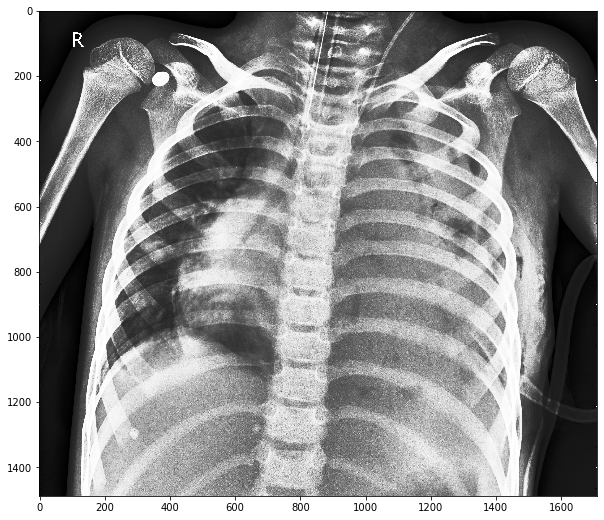

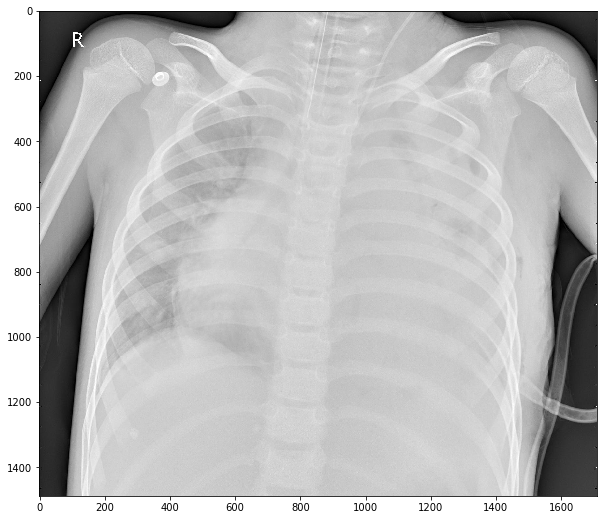

In [138]:
fig = plt.figure(figsize=(10, 10))
#plt.imshow(image, cmap="gray")
plt.imshow(img)
plt.show()
##############
fig = plt.figure(figsize=(10, 10))
#plt.imshow(image, cmap="gray")
plt.imshow(_img)
plt.show()